In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Let's train the model again first - to use its results later in this notebook

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [10]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

## Accuracy

In [11]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8026881720430108

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026881720430108

In [14]:
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [15]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.05 0.497
0.10 0.590
0.15 0.641
0.20 0.690
0.25 0.730
0.30 0.753
0.35 0.769
0.40 0.781
0.45 0.797
0.50 0.803
0.55 0.792
0.60 0.790
0.65 0.787
0.70 0.771
0.75 0.751
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


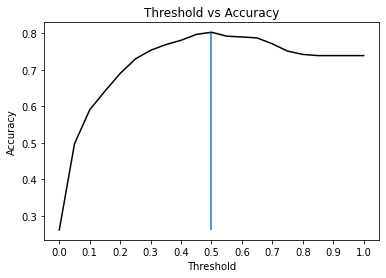

In [16]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

#plotting the line with max accuracy
plt.vlines(thresholds[np.argmax(accuracies)], min(accuracies), max(accuracies))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [17]:
churn_small = y_pred_small >= 0.5
(churn_small == y_val).mean()

0.7655913978494624

In [18]:
accuracy_score(y_val, churn_small)

0.7655913978494624

In [19]:
#Check how many people churn for 100% probability
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1860})

In [20]:
#So basically above says no one is going to churn
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

In [21]:
#Baseline and dummy model
accuracy_score(baseline, y_val)

0.7387096774193549

In [22]:
#Current accuracy
accuracy_score(y_pred=(y_pred >= 0.5), y_true=y_val)

0.8026881720430108

## Confusion table

In [23]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [24]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1207,  167],
       [ 200,  286]])

In [25]:
confusion_table / confusion_table.sum()

array([[0.64892473, 0.08978495],
       [0.10752688, 0.15376344]])

In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_val, y_pred=(y_pred>= 0.5))

array([[1207,  167],
       [ 200,  286]])

## Precision and recall

In [27]:
#Precision tells us how many positive predictions turned out to be correct amongst predicted positives

precision = true_positive/(true_positive + false_positive)

#Recall tells us how many postive predictions turned out to be correct amongst actual postives
recall = true_positive/(true_positive + false_negative)
precision, recall


(0.6313465783664459, 0.588477366255144)

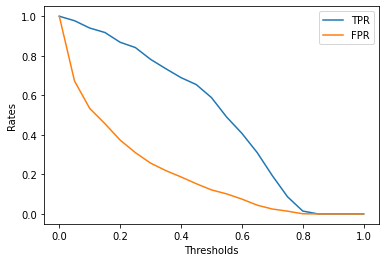

In [28]:
#minimise FPR and maximise TPR
def false_positive_rate(TN,FP):
    return FP/(TN+FP)

def true_positive_rate(FN, TP):
    return TP/(FN+TP)


def tpr_fpr_frame(y_val, y_pred):
    
    scores = []
    thresholds = np.linspace(0,1,21)

    for t in thresholds:
        TP = ((y_val == 1) & (y_pred >= t)).sum()
        FP = ((y_val == 0) & (y_pred >= t)).sum()

        TN = ((y_val == 0) & (y_pred < t)).sum()
        FN = ((y_val == 1) & (y_pred < t)).sum()

        FPR = false_positive_rate(TN, FP)
        TPR = true_positive_rate(FN, TP)

        scores.append((TP, FP, TN, FN, FPR, TPR, t))

    df = pd.DataFrame(data=scores, columns=['TP','FP', 'TN','FN', 'FPR', 'TPR','Threshold'])
    
    return df

df_model = tpr_fpr_frame(y_val, y_pred)
plt.plot(df_model.Threshold, df_model.TPR, label='TPR')
plt.plot(df_model.Threshold, df_model.FPR, label='FPR')
plt.xlabel('Thresholds')
plt.ylabel('Rates')
plt.legend()
plt.show()


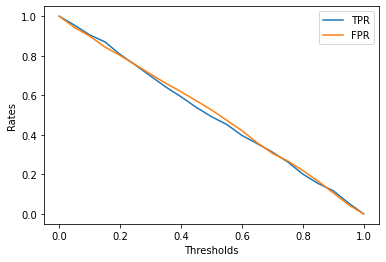

In [29]:
## Random Model

np.random.seed(1)
pred_rand = np.random.uniform(0,1,size=len(y_val))
df_rand = tpr_fpr_frame(y_val, pred_rand)
plt.plot(df_rand.Threshold, df_rand.TPR, label='TPR')
plt.plot(df_rand.Threshold, df_rand.FPR, label='FPR')
plt.xlabel('Thresholds')
plt.ylabel('Rates')
plt.legend()
plt.show()


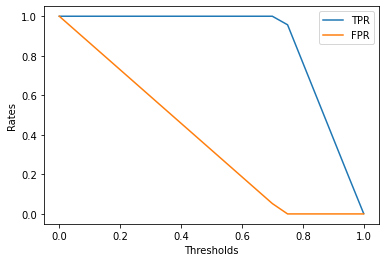

In [30]:
## Ideal Model
negative_class = (y_val == 0).sum()
positive_class = (y_val == 1).sum()
val_ideal = np.repeat([0,1], [negative_class, positive_class])
pred_ideal = np.linspace(0,1,len(y_val))

df_ideal = tpr_fpr_frame(val_ideal, pred_ideal)
plt.plot(df_ideal.Threshold, df_ideal.TPR, label='TPR')
plt.plot(df_ideal.Threshold, df_ideal.FPR, label='FPR')
plt.xlabel('Thresholds')
plt.ylabel('Rates')
plt.legend()
plt.show()

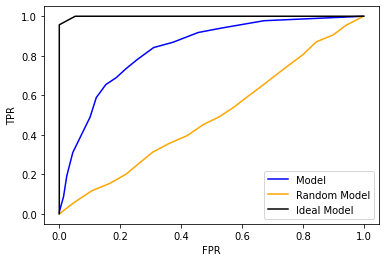

In [31]:
#
plt.plot(df_model.FPR, df_model.TPR, label = 'Model', color='b')
plt.plot(df_rand.FPR, df_rand.TPR, label = 'Random Model', color='orange')
plt.plot(df_ideal.FPR, df_ideal.TPR, label = 'Ideal Model', color='black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()


## ROC and AUC

TPR and FPR

In [32]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [33]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,457,733,29,641
20,0.2,422,513,64,861
30,0.3,380,353,106,1021
40,0.4,335,257,151,1117
50,0.5,286,167,200,1207
60,0.6,198,103,288,1271
70,0.7,94,34,392,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [34]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [35]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,457,733,29,641,0.940329,0.533479
20,0.2,422,513,64,861,0.868313,0.373362
30,0.3,380,353,106,1021,0.781893,0.256914
40,0.4,335,257,151,1117,0.689300,0.187045
50,0.5,286,167,200,1207,0.588477,0.121543
60,0.6,198,103,288,1271,0.407407,0.074964
70,0.7,94,34,392,1340,0.193416,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


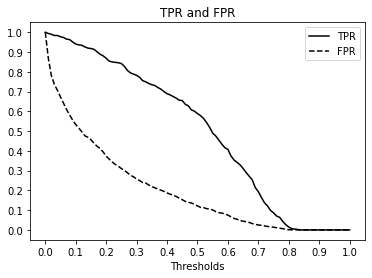

In [36]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

Random baseline

In [37]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [38]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


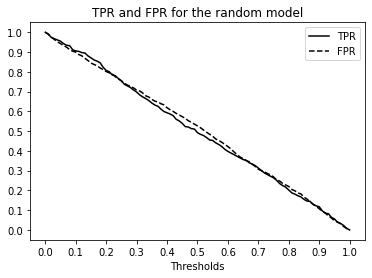

In [39]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

#plt.savefig('04_fpr_tpr_plot_random.svg')

plt.show()

Ideal baseline:

In [40]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


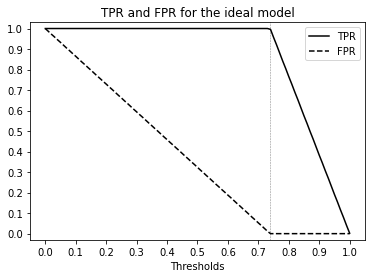

In [41]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

ROC curve

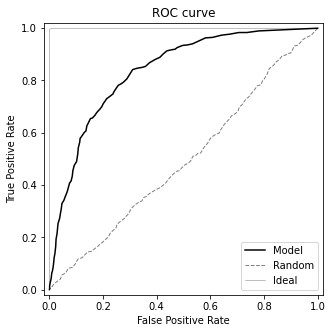

In [42]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

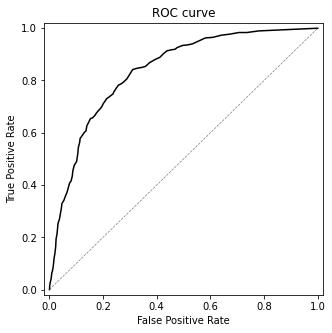

In [43]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve.svg')

plt.show()

Using Scikit-Learn for plotting the ROC curve

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [45]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [46]:
#sklearn vs ours
auc(fpr, tpr) , auc(df_model.FPR, df_model.TPR)

(0.8367185113303504, 0.834899006235736)

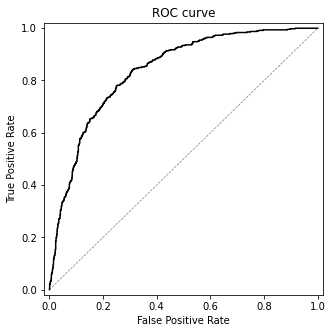

In [47]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

AUC: Area under the ROC curve

In [48]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)

In [49]:
auc(df_scores.fpr, df_scores.tpr)

0.8361209948424893

In [50]:
auc(df_scores_small.fpr, df_scores_small.tpr)

0.8114333806554411

Comparing multiple models with ROC curves

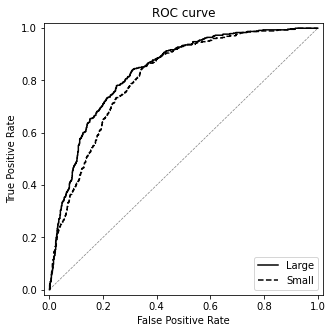

In [51]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(5, 5))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
roc_auc_score(y_val, y_pred)

0.8367185113303504

In [54]:
roc_auc_score(y_val, y_pred_small)

0.8123423844352196

In [55]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

Interpretation of AUC: the probability that a randomly chosen positive example
ranks higher than a randomly chosen negative example

In [56]:
np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=5000000)
pos_choice = np.random.randint(low=0, high=len(pos), size=5000000)

(pos[pos_choice] > neg[neg_choice]).mean()

0.836543

## K-fold cross-validation

In [57]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [58]:
from sklearn.model_selection import KFold

In [59]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

aucs = []

for train_idx, val_idx in kfold.split(X=df_train_full):
    
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values
    
    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    rocauc = roc_auc_score(y_val, y_pred)
    
    aucs.append(rocauc)

In [60]:
np.array(aucs).round(3)

array([0.845, 0.842, 0.859, 0.833, 0.823, 0.831, 0.843, 0.824, 0.845,
       0.861])

In [61]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.841 ± 0.012


Tuning the parameter `C`

In [62]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [63]:
from tqdm.auto import tqdm

In [64]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 10]):
    aucs = []

    for train_idx, val_idx in tqdm(kfold.split(df_train_full)):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C=0.001, auc = 0.824 ± 0.013


0it [00:00, ?it/s]

C=0.01, auc = 0.839 ± 0.008


0it [00:00, ?it/s]

C=0.1, auc = 0.841 ± 0.008


0it [00:00, ?it/s]

C=0.5, auc = 0.841 ± 0.007


0it [00:00, ?it/s]

C=1, auc = 0.841 ± 0.008


0it [00:00, ?it/s]

C=10, auc = 0.841 ± 0.008


Full retrain

In [65]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858


In [66]:
df_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [67]:
for i in df_train_full.columns:
    if i != 'churn' and df[i].dtype != 'object':
        score = roc_auc_score(df_train.churn, df_train[i])
        if score < 0.5:
            score = 1 - score
        print("Score %.2f for %s" % (score, i))

Score 0.56 for seniorcitizen
Score 0.73 for tenure
Score 0.63 for monthlycharges
Score 0.64 for totalcharges
